#### Libraries

In [1]:
from copy import deepcopy
import gc
from datetime import datetime
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import heapq
import time
import math
import cv2
import sys
import pickle
from scipy import signal
import os

In [ ]:
#Chromosome structure.
class Chromosome(object):

    def __init__(self, chromosome):
        self.chromosome = chromosome[:]
        self.fitness = -1

    def convolution2D(self):
        #Description of kernel based on chromosome.
        kernel = np.asarray(self.chromosome)
        kernel = kernel.reshape((7,7))
        #Load ideal image to convolve the kernel with.
        img_ideal = cv2.imread('deflared_img.jpg',0)
        canvas_size = (100, 100)
        img_ideal = cv2.resize(img_ideal, canvas_size, interpolation = cv2.INTER_AREA)

        convolved_img = signal.convolve2d(img_ideal, kernel, boundary='symm', mode="same")

        #convolved_img = np.zeros(shape=(input_img.shape[0], input_img.shape[1]))
        #zeros_padd = int(len(kernel)/2)
        #new_width = input_img.shape[0] + zeros_padd
        #new_height = input_img.shape[1] + zeros_padd
        #padded_img = cv2.copyMakeBorder(input_img, zeros_padd, zeros_padd, zeros_padd, zeros_padd, cv2.BORDER_CONSTANT,value=0)
        #for i in range(input_img.shape[0]):
          #for j in range(input_img.shape[1]):
              #convolved_img[i][j] = int(np.sum(np.multiply(padded_img[i:i+len(kernel), j:j+len(kernel)], kernel)))

        return convolved_img

    def crossover_onepoint(self, other):
        #Definition of Cossover "OnePoint".
        #Obtain cut point in a random way, considering chromosome size.
        cut = random.randrange(len(self.chromosome))
        if cut > len(other.chromosome):
            cut = len(other.chromosome)
        child1 = Chromosome(self.chromosome[:cut] + other.chromosome[cut:])
        child2 = Chromosome(other.chromosome[:cut] + self.chromosome[cut:])

        return [child1, child2]

    def crossover_uniform(self, other):
        #Definition of Cossover "Uniform".
        chromosome1 = deepcopy(self.chromosome)
        chromosome2 = deepcopy(other.chromosome)
        if (len(self.chromosome) > len(other.chromosome)):
            top_size = deepcopy(other.chromosome)
        else:
            top_size = deepcopy(self.chromosome)

        for i in range(len(top_size)):
            if random.uniform(0, 1) < 0.5:
                chromosome1[i] = self.chromosome[i]
                chromosome2[i] = other.chromosome[i]
            else:
                chromosome1[i] = other.chromosome[i]
                chromosome2[i] = self.chromosome[i]
        child1 = Chromosome(chromosome1)
        child2 = Chromosome(chromosome2)

        return [child1, child2]

    def crossover_arithmetic_unique(self, other):
        #Definition of Cossover Arithmetic Unique
        #for one gene defined in a random way:
        # chromosome1 = alpha*self + (1−alpha)*other
        # chromosome2 = alpha*other + (1−alpha)*self
        chromosome1 = deepcopy(self.chromosome)
        chromosome2 = deepcopy(other.chromosome)
        x_max = self.chromosome[0].size[0]
        y_max = self.chromosome[0].size[1]
        alpha = random.uniform(0, 1)
        #Obtain gene in random manner.
        cut = random.randrange(len(self.chromosome))
        if cut >= len(other.chromosome):
            cut = (len(other.chromosome)-1)
        #Generate first offspring:
        chromosome1[cut] = (alpha*self.chromosome[cut] + (other.chromosome[cut])*(1-alpha))
        #Generate second offspring:
        chromosome2[cut] = (alpha*other.chromosome[cut] + (self.chromosome[cut])*(1-alpha))

        child1 = Chromosome(chromosome1)
        child2 = Chromosome(chromosome2)

        return [child1, child2]

    def crossover_arithmetic(self, other):
        #Definition of Cossover "Airthmetic Complete".
        # chromosome1 = alpha*self + (1−alpha)*other
        # chromosome2 = alpha*other + (1−alpha)*self
        if (len(self.chromosome) > len(other.chromosome)):
            top_size = deepcopy(other.chromosome)
        else:
            top_size = deepcopy(self.chromosome)

        chromosome1 = deepcopy(self.chromosome)
        chromosome2 = deepcopy(other.chromosome)

        alpha = random.uniform(0, 1)

        for i in range(len(top_size)):
            chromosome1[i] = (alpha*self.chromosome[i] + (other.chromosome[i])*(1-alpha))
            chromosome2[i]= (alpha*other.chromosome[i] + (self.chromosome[i])*(1-alpha))

        child1 = Chromosome(chromosome1)
        child2 = Chromosome(chromosome2)

        return [child1, child2]

    def mutate_singlegene(self, intensity_mutation, p_add_gene):
        #Definition of Muration "Single-Gene".
        mutated_chromosome = deepcopy(self.chromosome)
        mutGene = random.randrange(0,len(mutated_chromosome))
        mutated_chromosome[mutGene] = random.uniform(0.01, 0.05) + (random.uniform(-0.02, 0.02) * intensity_mutation)

        return Chromosome(mutated_chromosome)

    def mutate_allgenes(self, intensity_mutation, p_add_gene):
        #Definition of Mutation "All-Gene".
        mutated_chromosome = deepcopy(self.chromosome)
        mutation_type = random.choice(mutated_chromosome[0].params)

        for i in range(len(mutated_chromosome)):
            mutated_chromosome[i] = random.uniform(0.01, 0.05) + (random.uniform(-0.02, 0.02) * intensity_mutation)

        return Chromosome(mutated_chromosome)

#-------------------------------------- Fitness-----------------------------------------#

def calculate_fitness(img_reference, chromosome):
    #Calculate fitness
    img_1 = np.array(img_reference,np.int32)
    #Image generation from convolution process.
    img_2 = np.array(chromosome.convolution2D(),np.int32)
    #MSE between both images.
    diference_img = np.sum(np.abs(img_1-img_2))
    #Fitness:::
    fitness = (1 / (diference_img + 1))*100

    return fitness

#------------------------------ Initialize Chromosome Population ----------------------------#

def init_population(popsize, chromosome_size, canvas_size):
    #Create initial population with required chromosome structure.
    population = []
    for i in range(popsize):
        new_chromosome = [random.uniform(0.01, 0.05) for j in range(chromosome_size)]
        population.append(Chromosome(new_chromosome))
    return population

#-------------------------------- Evaluate Chromosome Population ------------------------------#

def evaluate_population(population, img_reference):
    #Evaluate fitness in population.
    for i in range(len(population)):
        if population[i].fitness == -1:
            population[i].fitness = calculate_fitness(img_reference, population[i])
    return population

#-------------------------------- Selection Operators ------------------------------#

def select_parents_roulette(population):
    pop_size = len(population)
    ind_Parent1 = 0
    ind_Parent2 = 0
    #Select firs father.
    total_pop_fitness = sum([chromosome.fitness for chromosome in population])
    random_fitness = random.uniform(0, total_pop_fitness)
    sum_fitness = 0
    for i in range(pop_size):
        sum_fitness = sum_fitness + population[i].fitness
        if sum_fitness >= random_fitness:
            ind_Parent1 = i
            break

    #Select second father.
    total_pop_fitness = total_pop_fitness - population[ind_Parent1].fitness
    random_fitness = random.uniform(0, total_pop_fitness)
    sum_fitness = 0
    for i in range(pop_size):
        if i == ind_Parent1: continue
        sum_fitness = sum_fitness + population[i].fitness
        if sum_fitness >= random_fitness:
            ind_Parent2 = i
            break
    return (population[ind_Parent1], population[ind_Parent2])


def select_parents_tournament(population,size_torneo):
    #Select firs father.
    list_chromosomes=[]
    x1 = np.random.permutation(len(population))
    y1= x1[0:size_torneo]
    for i in range(size_torneo):
        list_chromosomes.append(population[y1[i]].fitness)
    max_ind = np.argmax(list_chromosomes)
    ind_parent1 = x1[max_ind]

    #Select second father.
    list_chromosomes=[]
    x2 = np.delete(x1, max_ind)
    x2 = np.random.permutation(x2)
    y2= x2[0:size_torneo]
    for i in range(size_torneo):
        list_chromosomes.append(population[y2[i]].fitness)
    max_ind=np.argmax(list_chromosomes)
    ind_parent2 = x2[max_ind]

    return (population[ind_parent1],population[ind_parent2])

#-------------------------------- Survivors Selection Operator ------------------------------#

def select_survivors_ranking(population, child_population, numsurvivors):
    new_population = []
    population.extend(child_population) #merge both populations.
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness,reverse=True)[:numsurvivors]
    for i in range(numsurvivors):
        new_population.append(population[isurvivors[i]])
    return new_population

#------------------------------------------ Instantiate Genetic Algorithm ----------------------------------------#

def genetic_algorithm(population, img_reference, total_gen=100, p_mut=0.1, p_add_gene = 0.1, intensity_mut=0.5,
                      crossover="onepoint", mutation="singlegene",
                      selection_parents_method="roulette",
                      selection_survivors_method="ranking"):

    pop_size = len(population)
    #Evaluate Initial Population.
    evaluate_population(population, img_reference)
    #Obtain best individual.
    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness)[:1]
    best_fitness = [population[ibest[0]].fitness]
    count = 0
    print("Fitness Inicial = {}".format(population[ibest[0]].fitness))

    for gen in range(total_gen):
        print("Generation #", gen)
        if (crossover != "none"):
            mating_pool = []
            mating_pool_size = int(pop_size/2)
            if selection_parents_method=="roulette":
                for i in range(mating_pool_size):
                    mating_pool.append(select_parents_roulette(population))
            elif selection_parents_method=="tournament":
                for i in range(mating_pool_size):
                    mating_pool.append(select_parents_tournament(population,3))
            else:
                raise NotImplementedError

            #Apply crossover on the parents.
            child_population = []
            for i in range(len(mating_pool)):
                if crossover == "onepoint":
                    child_population.extend(mating_pool[i][0].crossover_onepoint(mating_pool[i][1]))
                elif crossover == "uniform":
                    child_population.extend(mating_pool[i][0].crossover_uniform(mating_pool[i][1]))
                elif crossover == "arithmetic_complete":
                    child_population.extend(mating_pool[i][0].crossover_arithmetic(mating_pool[i][1]))
                elif crossover == "arithmetic_unique":
                    child_population.extend(mating_pool[i][0].crossover_arithmetic_unique(mating_pool[i][1]))
                else:
                    raise NotImplementedError

            #Apply mutation on the offsprings.
            for i in range(len(child_population)):
                if random.uniform(0, 1) < p_mut:
                    if mutation == "singlegene":
                        child_population[i] = child_population[i].mutate_singlegene(intensity_mut, p_add_gene)
                    elif mutation == "allgenes":
                        child_population[i] = child_population[i].mutate_allgenes(intensity_mut, p_add_gene)
                    else:
                        raise NotImplementedError

            #Evaluate new population
            evaluate_population(child_population, img_reference)

            #Select best survivors.
            if selection_survivors_method == "ranking":
                population = select_survivors_ranking(population, child_population, pop_size)
            else:
                raise NotImplementedError

        #In case there is no crossover selected.
        else:
            #Apply only mutation
            for i in range(len(population)):
                if random.uniform(0, 1) < p_mut:
                    if mutation == "singlegene":
                        population[i] = population[i].mutate_singlegene(intensity_mut, p_add_gene)
                    elif mutation == "allgenes":
                        population[i] = population[i].mutate_allgenes(intensity_mut, p_add_gene)
                    else:
                        raise NotImplementedError

            evaluate_population(population, img_reference)

            if selection_survivors_method == "ranking":
                population = select_survivors_ranking(population, [], pop_size)
            else:
                raise NotImplementedError

        #Obtain best individual:
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness)[:1]
        #Obtain best fitness:
        best_fitness.append(population[ibest[0]].fitness)

        #Save image.
        if (gen) % 10 == 0:
            #img_name = "/content/drive/MyDrive/Master Thesis/Images_Test/img_" + str(i) + ".png"
            img = population[ibest[0]].convolution2D()
            #cv2.imwrite(img_name, img)
            cv2_imshow(img)

    return population[ibest[0]], best_fitness, population[ibest[0]].chromosome


**Main Program**

Image Deglared Shape: (100, 100)


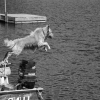

Image Glared Shape: (100, 100)


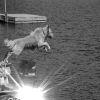

In [ ]:
#Read reference image
img_ideal = cv2.imread('deflared_img.jpg', 0)
img_obs = cv2.imread('flared_img.jpg', 0)
canvas_size = (100, 100)
img_ideal = cv2.resize(img_ideal, canvas_size, interpolation = cv2.INTER_AREA)
img_obs = cv2.resize(img_obs, canvas_size, interpolation = cv2.INTER_AREA)
print("Image Deglared Shape:", img_ideal.shape)
cv2_imshow(img_ideal)
print("Image Glared Shape:", img_obs.shape)
cv2_imshow(img_obs)

Iteration #: 0
Fitness Inicial = 0.0001259434740499769
Generation # 0


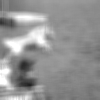

Generation # 1
Generation # 2
Generation # 3
Generation # 4
Generation # 5
Generation # 6
Generation # 7
Generation # 8
Generation # 9
Generation # 10


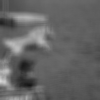

Generation # 11
Generation # 12
Generation # 13
Generation # 14
Generation # 15
Generation # 16
Generation # 17
Generation # 18
Generation # 19
Generation # 20


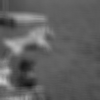

Generation # 21
Generation # 22
Generation # 23
Generation # 24
Generation # 25
Generation # 26
Generation # 27
Generation # 28
Generation # 29
Generation # 30


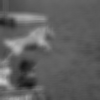

Generation # 31
Generation # 32
Generation # 33
Generation # 34
Generation # 35
Generation # 36
Generation # 37
Generation # 38
Generation # 39
Generation # 40


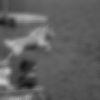

Generation # 41
Generation # 42
Generation # 43
Generation # 44
Generation # 45
Generation # 46
Generation # 47
Generation # 48
Generation # 49
Generation # 50


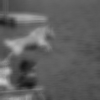

Generation # 51
Generation # 52
Generation # 53
Generation # 54
Generation # 55
Generation # 56
Generation # 57
Generation # 58
Generation # 59
Generation # 60


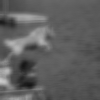

Generation # 61
Generation # 62
Generation # 63
Generation # 64
Generation # 65
Generation # 66
Generation # 67
Generation # 68
Generation # 69
Generation # 70


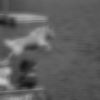

Generation # 71
Generation # 72
Generation # 73
Generation # 74
Generation # 75
Generation # 76
Generation # 77
Generation # 78
Generation # 79
Generation # 80


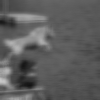

Generation # 81
Generation # 82
Generation # 83
Generation # 84
Generation # 85
Generation # 86
Generation # 87
Generation # 88
Generation # 89
Generation # 90


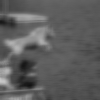

Generation # 91
Generation # 92
Generation # 93
Generation # 94
Generation # 95
Generation # 96
Generation # 97
Generation # 98
Generation # 99
Generation # 100


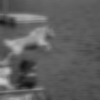

Generation # 101
Generation # 102
Generation # 103
Generation # 104
Generation # 105
Generation # 106
Generation # 107
Generation # 108
Generation # 109
Generation # 110


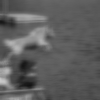

Generation # 111
Generation # 112
Generation # 113
Generation # 114
Generation # 115
Generation # 116
Generation # 117
Generation # 118
Generation # 119
Generation # 120


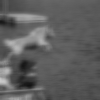

Generation # 121
Generation # 122
Generation # 123
Generation # 124
Generation # 125
Generation # 126
Generation # 127
Generation # 128
Generation # 129
Generation # 130


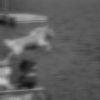

Generation # 131
Generation # 132
Generation # 133
Generation # 134
Generation # 135
Generation # 136
Generation # 137
Generation # 138
Generation # 139
Generation # 140


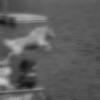

Generation # 141
Generation # 142
Generation # 143
Generation # 144
Generation # 145
Generation # 146
Generation # 147
Generation # 148
Generation # 149
Generation # 150


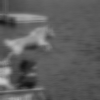

Generation # 151
Generation # 152
Generation # 153
Generation # 154
Generation # 155
Generation # 156
Generation # 157
Generation # 158
Generation # 159
Generation # 160


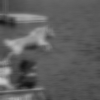

Generation # 161
Generation # 162
Generation # 163
Generation # 164
Generation # 165
Generation # 166
Generation # 167
Generation # 168
Generation # 169
Generation # 170


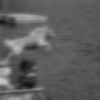

Generation # 171
Generation # 172
Generation # 173
Generation # 174
Generation # 175
Generation # 176
Generation # 177
Generation # 178
Generation # 179
Generation # 180


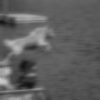

Generation # 181
Generation # 182
Generation # 183
Generation # 184
Generation # 185
Generation # 186
Generation # 187
Generation # 188
Generation # 189
Generation # 190


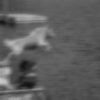

Generation # 191
Generation # 192
Generation # 193
Generation # 194
Generation # 195
Generation # 196
Generation # 197
Generation # 198
Generation # 199
Generation # 200


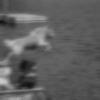

Generation # 201
Generation # 202
Generation # 203
Generation # 204
Generation # 205
Generation # 206
Generation # 207
Generation # 208
Generation # 209
Generation # 210


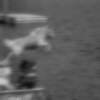

Generation # 211
Generation # 212
Generation # 213
Generation # 214
Generation # 215
Generation # 216
Generation # 217
Generation # 218
Generation # 219
Generation # 220


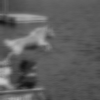

Generation # 221
Generation # 222
Generation # 223
Generation # 224
Generation # 225
Generation # 226
Generation # 227
Generation # 228
Generation # 229
Generation # 230


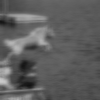

Generation # 231
Generation # 232
Generation # 233
Generation # 234
Generation # 235
Generation # 236
Generation # 237
Generation # 238
Generation # 239
Generation # 240


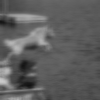

Generation # 241
Generation # 242
Generation # 243
Generation # 244
Generation # 245
Generation # 246
Generation # 247
Generation # 248
Generation # 249
Generation # 250


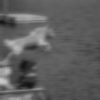

Generation # 251
Generation # 252
Generation # 253
Generation # 254
Generation # 255
Generation # 256
Generation # 257
Generation # 258
Generation # 259
Generation # 260


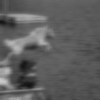

Generation # 261
Generation # 262
Generation # 263
Generation # 264
Generation # 265
Generation # 266
Generation # 267
Generation # 268
Generation # 269
Generation # 270


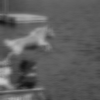

Generation # 271
Generation # 272
Generation # 273
Generation # 274
Generation # 275
Generation # 276
Generation # 277
Generation # 278
Generation # 279
Generation # 280


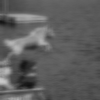

Generation # 281
Generation # 282
Generation # 283
Generation # 284
Generation # 285
Generation # 286
Generation # 287
Generation # 288
Generation # 289
Generation # 290


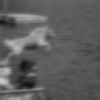

Generation # 291
Generation # 292
Generation # 293
Generation # 294
Generation # 295
Generation # 296
Generation # 297
Generation # 298
Generation # 299
Generation # 300


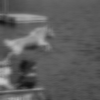

Generation # 301
Generation # 302
Generation # 303
Generation # 304
Generation # 305
Generation # 306
Generation # 307
Generation # 308
Generation # 309
Generation # 310


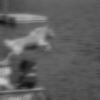

Generation # 311
Generation # 312
Generation # 313
Generation # 314
Generation # 315
Generation # 316
Generation # 317
Generation # 318
Generation # 319
Generation # 320


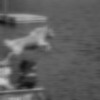

Generation # 321
Generation # 322
Generation # 323
Generation # 324
Generation # 325
Generation # 326
Generation # 327
Generation # 328
Generation # 329
Generation # 330


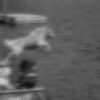

Generation # 331
Generation # 332
Generation # 333
Generation # 334
Generation # 335
Generation # 336
Generation # 337
Generation # 338
Generation # 339
Generation # 340


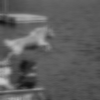

Generation # 341
Generation # 342
Generation # 343
Generation # 344
Generation # 345
Generation # 346
Generation # 347
Generation # 348
Generation # 349
Generation # 350


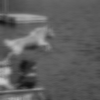

Generation # 351
Generation # 352
Generation # 353
Generation # 354
Generation # 355
Generation # 356
Generation # 357
Generation # 358
Generation # 359
Generation # 360


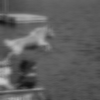

Generation # 361
Generation # 362
Generation # 363
Generation # 364
Generation # 365
Generation # 366
Generation # 367
Generation # 368
Generation # 369
Generation # 370


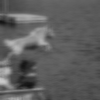

Generation # 371
Generation # 372
Generation # 373
Generation # 374
Generation # 375
Generation # 376
Generation # 377
Generation # 378
Generation # 379
Generation # 380


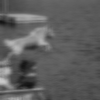

Generation # 381
Generation # 382
Generation # 383
Generation # 384
Generation # 385
Generation # 386
Generation # 387
Generation # 388
Generation # 389
Generation # 390


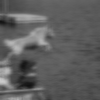

Generation # 391
Generation # 392
Generation # 393
Generation # 394
Generation # 395
Generation # 396
Generation # 397
Generation # 398
Generation # 399
Promedio del Fitness en las 10 ejecuciones: 0.0004902681766926509
Desviación Estandar del Fitness en las 10 ejecuciones: 0.0
Curva Promedio de Evolución del Fitness:


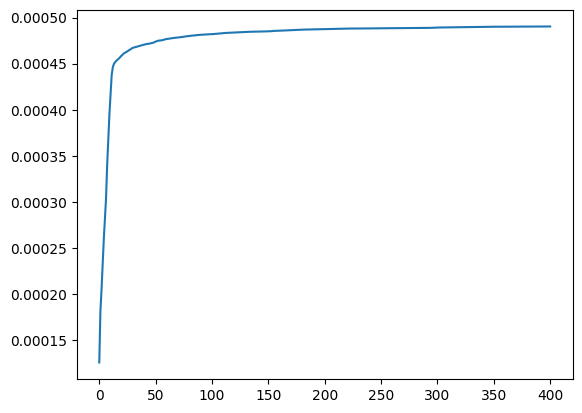

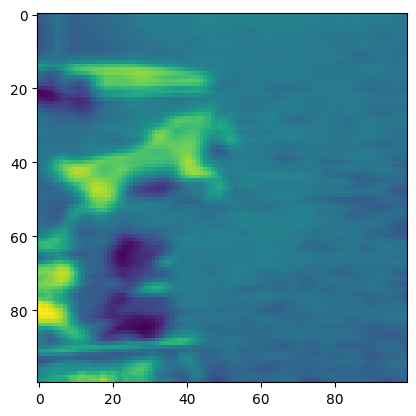

Best cromosoma: [0.007074198827751575, 0.0035590126668831063, 0.005140007356855439, 0.012989610482714645, 0.0024650876688743894, 0.00857628514537227, 0.008089837476670197, 0.004651300124275755, 0.0028987559264769067, 0.007039080808441657, 0.021436689156298525, 0.005785664633405648, 0.0060485415271861066, 0.0023194803871888804, 0.0024713430218796083, 0.003959292629884832, 0.022500861510530604, 0.057103282843685696, 0.041535452892804886, 0.020618770605852738, 0.009713665869759707, 0.046278014571977555, 0.05652565533048105, 0.05976360700781258, 0.05679116656071697, 0.058613149175352645, 0.058905486035434294, 0.05145095372454029, 0.004666597661337932, 0.010878332838567682, 0.041300220870255665, 0.0555648764529677, 0.05147237287934315, 0.00988596196344392, 0.007325523698493432, 0.004385483965491605, 0.002372885057438684, 0.007770565004076346, 0.02339602775785545, 0.0008333901143935431, 0.00418666585389073, 0.008238301020599545, 0.009284891933396832, 0.003619919587766575, 0.00306565111142545

In [ ]:
#------------------------------------------------TEST----------------------------------------------------#
# Crossover = "onepoint"
# Mutation = "singlegene", p_mut=1.0, p_add_gene=0.1, imut=0.5
# MetodoSeleccion = "tournament"
#------------------------------------------------------------------------------------------------------------#
chromosome_size = 49
population_size = 100
img_reference = img_ob
gens = 400
p_mut = 0.95
p_add_gene = 0.1
imut = 0.5
crossover=['onepoint','uniform','arithmetic']
mutation=['singlegene','allgenes']
metodoSeleccion=['roulette','tournament']
best_image = []
sum_fitness_curve = np.zeros(gens+1)
best_fit = []
best = 0
for i in range(1):
    population = init_population(population_size, chromosome_size, canvas_size)
    print("Iteration #:", i)
    best_ind, best_fitness, best_chromosome = genetic_algorithm(population, img_reference, gens, p_mut, p_add_gene,
                                                                imut, crossover[0], mutation[0], metodoSeleccion[1])

    best_image.append(best_ind)
    sum_fitness_curve = np.add(sum_fitness_curve, best_fitness)
    best_fit.append(best_fitness[gens-1])
    gc.collect()

fitness_mean = np.sum(np.array(best_fit))/len(best_fit)
fitness_std = np.std(np.array(best_fit))
mean_fitness_curve = (sum_fitness_curve)/len(best_fit)

print("Mean Fitness:", fitness_mean)
print("STD Fitness:", fitness_std)
print("Fitness Curve:")
plt.plot(mean_fitness_curve)
plt.show()

img = best_image[0].convolution2D()
plt.imshow(img)

plt.show()
print("Best chromosome:", best_chromosome)